<a href="https://colab.research.google.com/github/Shisiajoy/SENTIMENT-ANALYSIS-TWEETS/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTS

In [1]:
!pip install nltk


In [9]:
!pip install wordcloud


In [37]:
import nltk
from nltk.corpus import twitter_samples
import matplotlib.pyplot as plt
import re
import pandas as pd
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score




In [3]:
# Download the dataset
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


True

In [4]:
# Loading positive and negative tweets
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

## CHECK DISTRIBUTION

In [5]:
# Get the count of positive and negative tweets
num_positive_tweets = len(positive_tweets)
num_negative_tweets = len(negative_tweets)

print(f"Number of positive tweets: {num_positive_tweets}")
print(f"Number of negative tweets: {num_negative_tweets}")


Number of positive tweets: 5000
Number of negative tweets: 5000


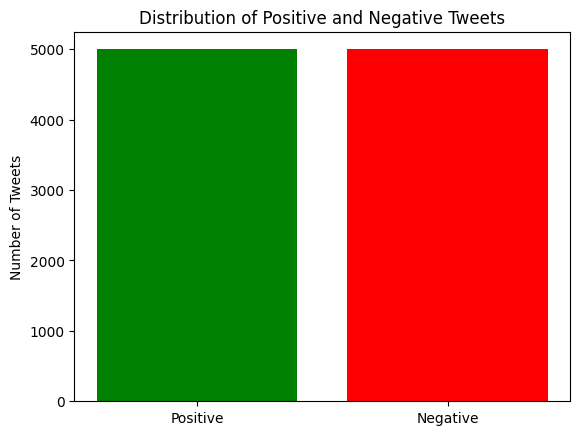

In [6]:
# Plotting the distribution of tweets
labels = ['Positive', 'Negative']
tweet_counts = [num_positive_tweets, num_negative_tweets]

plt.bar(labels, tweet_counts, color=['green', 'red'])
plt.title('Distribution of Positive and Negative Tweets')
plt.ylabel('Number of Tweets')
plt.show()


## CLEAN TWEETS

-Remove the noise (links, mentions, etc.).

In [8]:
def clean_tweet(tweet):
    tweet = re.sub(r"http\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"@\S+", "", tweet)  # Remove mentions
    tweet = re.sub(r"#\S+", "", tweet)  # Remove hashtags
    tweet = tweet.lower()  # Convert to lowercase
    return tweet

# Clean both positive and negative tweets
cleaned_positive_tweets = [clean_tweet(tweet) for tweet in positive_tweets]
cleaned_negative_tweets = [clean_tweet(tweet) for tweet in negative_tweets]


In [21]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [22]:
# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define text cleaning function
def clean_tweet(tweet):
    tweet = re.sub(r"http\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"@\S+", "", tweet)  # Remove mentions
    tweet = re.sub(r"#\S+", "", tweet)  # Remove hashtags
    tweet = re.sub(r'\d+', '', tweet)  # Remove digits
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tweet = tweet.lower()  # Convert to lowercase
    tweet = ' '.join([lemmatizer.lemmatize(word) for word in tweet.split() if word not in stop_words])  # Lemmatization and stopwords removal
    return tweet

# Clean both positive and negative tweets
cleaned_positive_tweets = [clean_tweet(tweet) for tweet in positive_tweets]
cleaned_negative_tweets = [clean_tweet(tweet) for tweet in negative_tweets]

# Output some cleaned examples for validation
print(cleaned_positive_tweets[:5])
print(cleaned_negative_tweets[:5])


['top engaged member community week', 'hey james odd please call contact centre able assist many thanks', 'listen last night bleed amazing track scotland', 'congrats', 'yeaaaah yippppy accnt verified rqst succeed got blue tick mark fb profile day']
['hopeless tmr', 'everything kid section ikea cute shame im nearly month', 'heart sliding waste basket', '“ hate japanese call ban ”', 'dang starting next week work']


In [26]:
# Create a DataFrame for both
positive_df = pd.DataFrame(cleaned_positive_tweets, columns=["Positive Tweets"])
negative_df = pd.DataFrame(cleaned_negative_tweets, columns=["Negative Tweets"])

# Display DataFrames
print("Positive Tweets:")
positive_df.head()



Positive Tweets:


,Positive Tweets
0,top engaged member community week
1,hey james odd please call contact centre able ...
2,listen last night bleed amazing track scotland
3,congrats
4,yeaaaah yippppy accnt verified rqst succeed go...


In [27]:
print("\nNegative Tweets:")
negative_df.head()


Negative Tweets:


,Negative Tweets
0,hopeless tmr
1,everything kid section ikea cute shame im near...
2,heart sliding waste basket
3,“ hate japanese call ban ”
4,dang starting next week work


## WORD CLOUD

- Positive word cloud

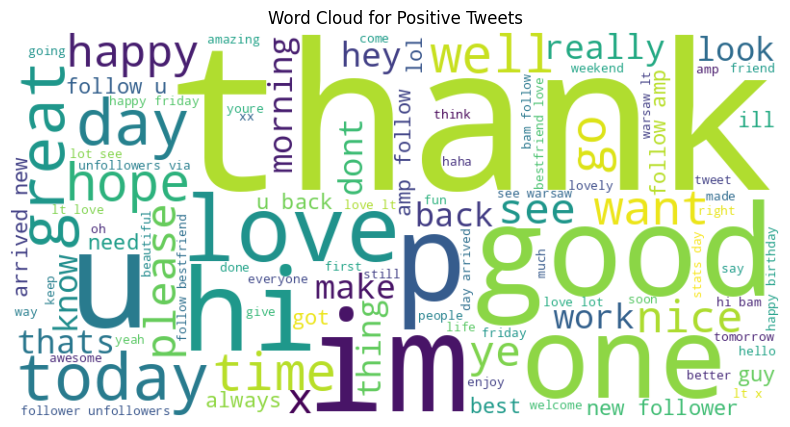

In [28]:
# Combine all positive tweets into a single string
positive_tweets_combined = ' '.join(cleaned_positive_tweets)

# Generate the word cloud for positive tweets
wordcloud_positive = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(positive_tweets_combined)

# Display the positive word cloud
plt.figure(figsize=(10, 5))
plt.title("Word Cloud for Positive Tweets")
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.show()


- Negative word cloud

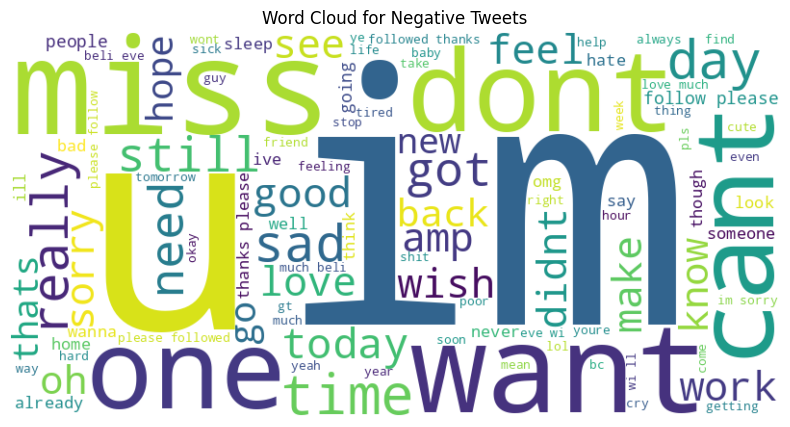

In [29]:
# Combine all negative tweets into a single string
negative_tweets_combined = ' '.join(cleaned_negative_tweets)

# Generate the word cloud for negative tweets
wordcloud_negative = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(negative_tweets_combined)

# Display the negative word cloud
plt.figure(figsize=(10, 5))
plt.title("Word Cloud for Negative Tweets")
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.show()


## CONVERT TWEETS INTO NUMBERS (ENCODING)

- using Bag of Words (BoW) encoding, where the CountVectorizer is creating a numerical representation of the words by counting their occurrences in the tweets.

In [30]:
# Combine positive and negative tweets into one dataset
all_tweets = cleaned_positive_tweets + cleaned_negative_tweets

# Convert words to numbers (features)
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(all_tweets).toarray()

# Labels: 1 for positive, 0 for negative
y = [1] * len(cleaned_positive_tweets) + [0] * len(cleaned_negative_tweets)


## TRAIN TEST SPLIT

In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## MODEL TRAINING

- Logistic regression

In [32]:
# Train a logistic regression model
model = LogisticRegression(C=1, penalty='l2', solver='lbfgs')
model.fit(X_train, y_train)


LogisticRegression()

In [19]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Print the accuracy and classification report
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.7535
              precision    recall  f1-score   support

           0       0.74      0.77      0.76       988
           1       0.77      0.73      0.75      1012

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



- Hyperparameter tunning

In [34]:
# Define the hyperparameters to test
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['lbfgs']}

# Grid search to find the best parameters
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X, y)

# Best parameters
print("Best parameters: ", grid.best_params_)


Best parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


- Random forest

In [41]:
# Train Random Forest on training data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Cross-validate on the training data
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print("Random Forest Cross-validated accuracy: ", rf_scores.mean())

# Evaluate the model on the test data
test_accuracy = rf_model.score(X_test, y_test)
print("Test set accuracy: ", test_accuracy)


Random Forest Cross-validated accuracy:  0.7193750000000001
Test set accuracy:  0.7445


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform Grid Search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)

# Evaluate on the test set
best_rf_model = grid_search.best_estimator_
test_accuracy = best_rf_model.score(X_test, y_test)
print("Test set accuracy with tuned parameters: ", test_accuracy)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
